In [1]:
# First we will import neccessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2 as cv
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Lambda

In [2]:
path = "/kaggle/input/mri-dataset/cleaned/train"
key_value= dict()
for i in os.listdir(path):
    key_value[i] = os.listdir(path+'/'+i)

In [3]:
df = []
for key in key_value.keys():
    for j in key_value[key]:
        df.append([key,path+'/'+key+'/'+j])
df1 = pd.DataFrame(df,columns=('label','path'))
df1

,label,path
0,pituitary,/kaggle/input/mri-dataset/cleaned/train/pituit...
1,pituitary,/kaggle/input/mri-dataset/cleaned/train/pituit...
2,pituitary,/kaggle/input/mri-dataset/cleaned/train/pituit...
3,pituitary,/kaggle/input/mri-dataset/cleaned/train/pituit...
4,pituitary,/kaggle/input/mri-dataset/cleaned/train/pituit...
...,...,...
5707,glioma,/kaggle/input/mri-dataset/cleaned/train/glioma...
5708,glioma,/kaggle/input/mri-dataset/cleaned/train/glioma...
5709,glioma,/kaggle/input/mri-dataset/cleaned/train/glioma...
5710,glioma,/kaggle/input/mri-dataset/cleaned/train/glioma...


In [4]:
def readimg(path):
    img= cv.imread(path)
    img = cv.resize(img,(256,256))
    return img

In [5]:
import multiprocessing

# Create a Pool with 4 worker processes
with multiprocessing.Pool(1) as p:
    # Read in all of the images in parallel
    images = p.map(readimg, df1['path'])


In [6]:
images=np.array(images)

y_labels = df1['label'].replace({'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}).values


In [7]:
# to split the data into training and testing data
train_images,val_images,train_labels,val_labels = train_test_split(images,y_labels,test_size=0.2, random_state=42)

In [8]:
from tensorflow.keras.layers import Dropout
base_model = keras.applications.ResNet50(weights='imagenet', include_top=False)
fine_tune_at = 170

base_model.trainable = True


for layer in base_model.layers[:fine_tune_at]:
    base_model.trainable = False
model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(256, activation='relu'),

    
  Dropout(0.1),
  keras.layers.Dense(4, activation='softmax'),
  #keras.layers.Dense(3, activation='softmax')

])
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.0001  # Adjust this value as needed

# Instantiate the Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [9]:
print("#/layers in base model: ", len(base_model.layers))


#/layers in base model:  175


In [10]:
model.fit(train_images,train_labels, epochs=20, batch_size=32,validation_data=(val_images, val_labels))

Epoch 1/20
143/143 [==============================] - 38s 155ms/step - loss: 0.5963 - accuracy: 0.7691 - val_loss: 0.3568 - val_accuracy: 0.8749
Epoch 2/20
143/143 [==============================] - 19s 134ms/step - loss: 0.3212 - accuracy: 0.8875 - val_loss: 0.2825 - val_accuracy: 0.8959
Epoch 3/20
143/143 [==============================] - 19s 135ms/step - loss: 0.2508 - accuracy: 0.9083 - val_loss: 0.2545 - val_accuracy: 0.9081
Epoch 4/20
143/143 [==============================] - 20s 137ms/step - loss: 0.2111 - accuracy: 0.9282 - val_loss: 0.2263 - val_accuracy: 0.9204
Epoch 5/20
143/143 [==============================] - 20s 139ms/step - loss: 0.1822 - accuracy: 0.9411 - val_loss: 0.2072 - val_accuracy: 0.9274
Epoch 6/20
143/143 [==============================] - 20s 139ms/step - loss: 0.1682 - accuracy: 0.9402 - val_loss: 0.1979 - val_accuracy: 0.9318
Epoch 7/20
143/143 [==============================] - 20s 139ms/step - loss: 0.1505 - accuracy: 0.9503 - val_loss: 0.1981 - val_ac

In [11]:
path = "/kaggle/input/mri-dataset/cleaned/val"
key_value= dict()
for i in os.listdir(path):
    key_value[i] = os.listdir(path+'/'+i)

In [12]:
dft = []
for key in key_value.keys():
    for j in key_value[key]:
        dft.append([key,path+'/'+key+'/'+j])
dft = pd.DataFrame(dft,columns=('label','path'))

In [13]:
with multiprocessing.Pool(1) as p:
    # Read in all of the images in parallel
    test_images = p.map(readimg, dft['path'])

In [14]:
test_images=np.array(test_images)

test_labels = dft['label'].replace({'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}).values


In [15]:
from sklearn.metrics import accuracy_score

# Make predictions on the test data
predictions = model.predict(test_images)

# Convert the predictions to the class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the accuracy score
accuracy = accuracy_score(test_labels, predicted_labels)

print('Accuracy:', accuracy)

41/41 [==============================] - 7s 130ms/step
Accuracy: 0.954233409610984


In [16]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.resnet50 import preprocess_input

# Preprocess the test images
preprocessed_images = preprocess_input(test_images)

# Initialize variables to store processing times
processing_times = []

# Iterate through each test image
for image in preprocessed_images:
    # Measure start time
    start_time = time.time()
    
    # Make prediction on the preprocessed test image
    prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)  # Expand dimensions to match batch shape
    
    # Measure end time
    end_time = time.time()
    
    # Calculate processing time
    processing_time = end_time - start_time
    
    # Store processing time
    processing_times.append(processing_time)

# Compute average processing time
average_processing_time = sum(processing_times) / len(processing_times)

# Print the average processing time
print("Average Processing Time:", average_processing_time)


Average Processing Time: 0.08122124570094384


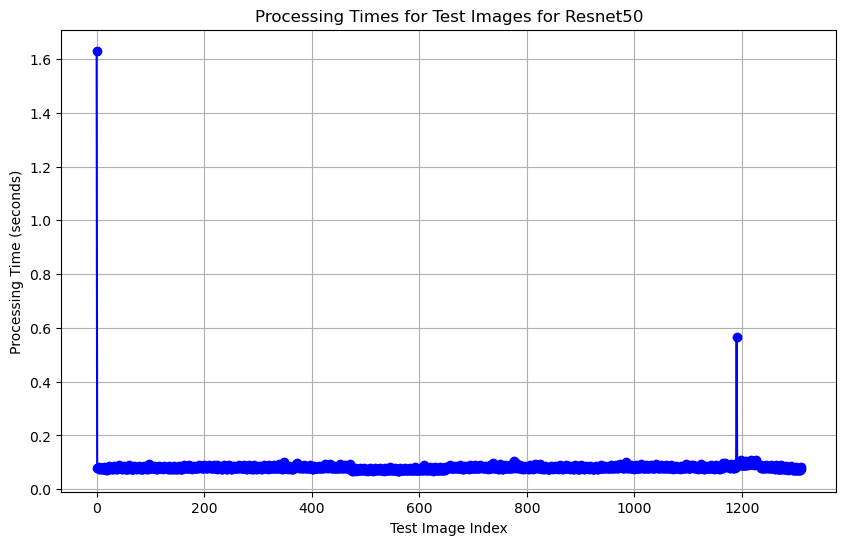

Average Processing Time: 0.08122124570094384


In [17]:
# Plot processing times
plt.figure(figsize=(10, 6))
plt.plot(processing_times, color='blue', marker='o', linestyle='-')
plt.title('Processing Times for Test Images for Resnet50')
plt.xlabel('Test Image Index')
plt.ylabel('Processing Time (seconds)')
plt.grid(True)
plt.show()

# Print the average processing time
print("Average Processing Time:", average_processing_time)

In [18]:
from sklearn.metrics import classification_report
target_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

report=classification_report(test_labels, predicted_labels,target_names=target_names, output_dict=True)
print(report)

{'glioma': {'precision': 0.9781021897810219, 'recall': 0.8933333333333333, 'f1-score': 0.9337979094076654, 'support': 300}, 'meningioma': {'precision': 0.8919753086419753, 'recall': 0.9444444444444444, 'f1-score': 0.9174603174603174, 'support': 306}, 'notumor': {'precision': 0.9926470588235294, 'recall': 1.0, 'f1-score': 0.996309963099631, 'support': 405}, 'pituitary': {'precision': 0.9475409836065574, 'recall': 0.9633333333333334, 'f1-score': 0.9553719008264463, 'support': 300}, 'accuracy': 0.954233409610984, 'macro avg': {'precision': 0.9525663852132711, 'recall': 0.9502777777777778, 'f1-score': 0.9507350226985151, 'support': 1311}, 'weighted avg': {'precision': 0.9554992031153681, 'recall': 0.954233409610984, 'f1-score': 0.9542329025693678, 'support': 1311}}


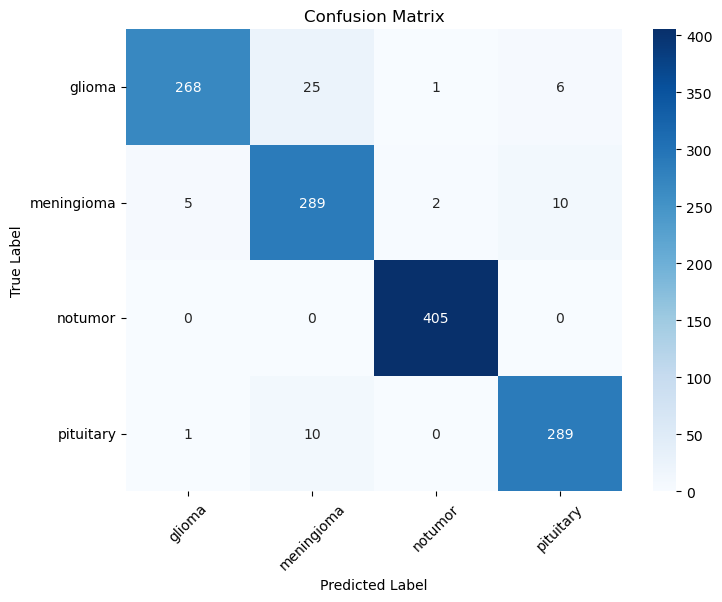

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


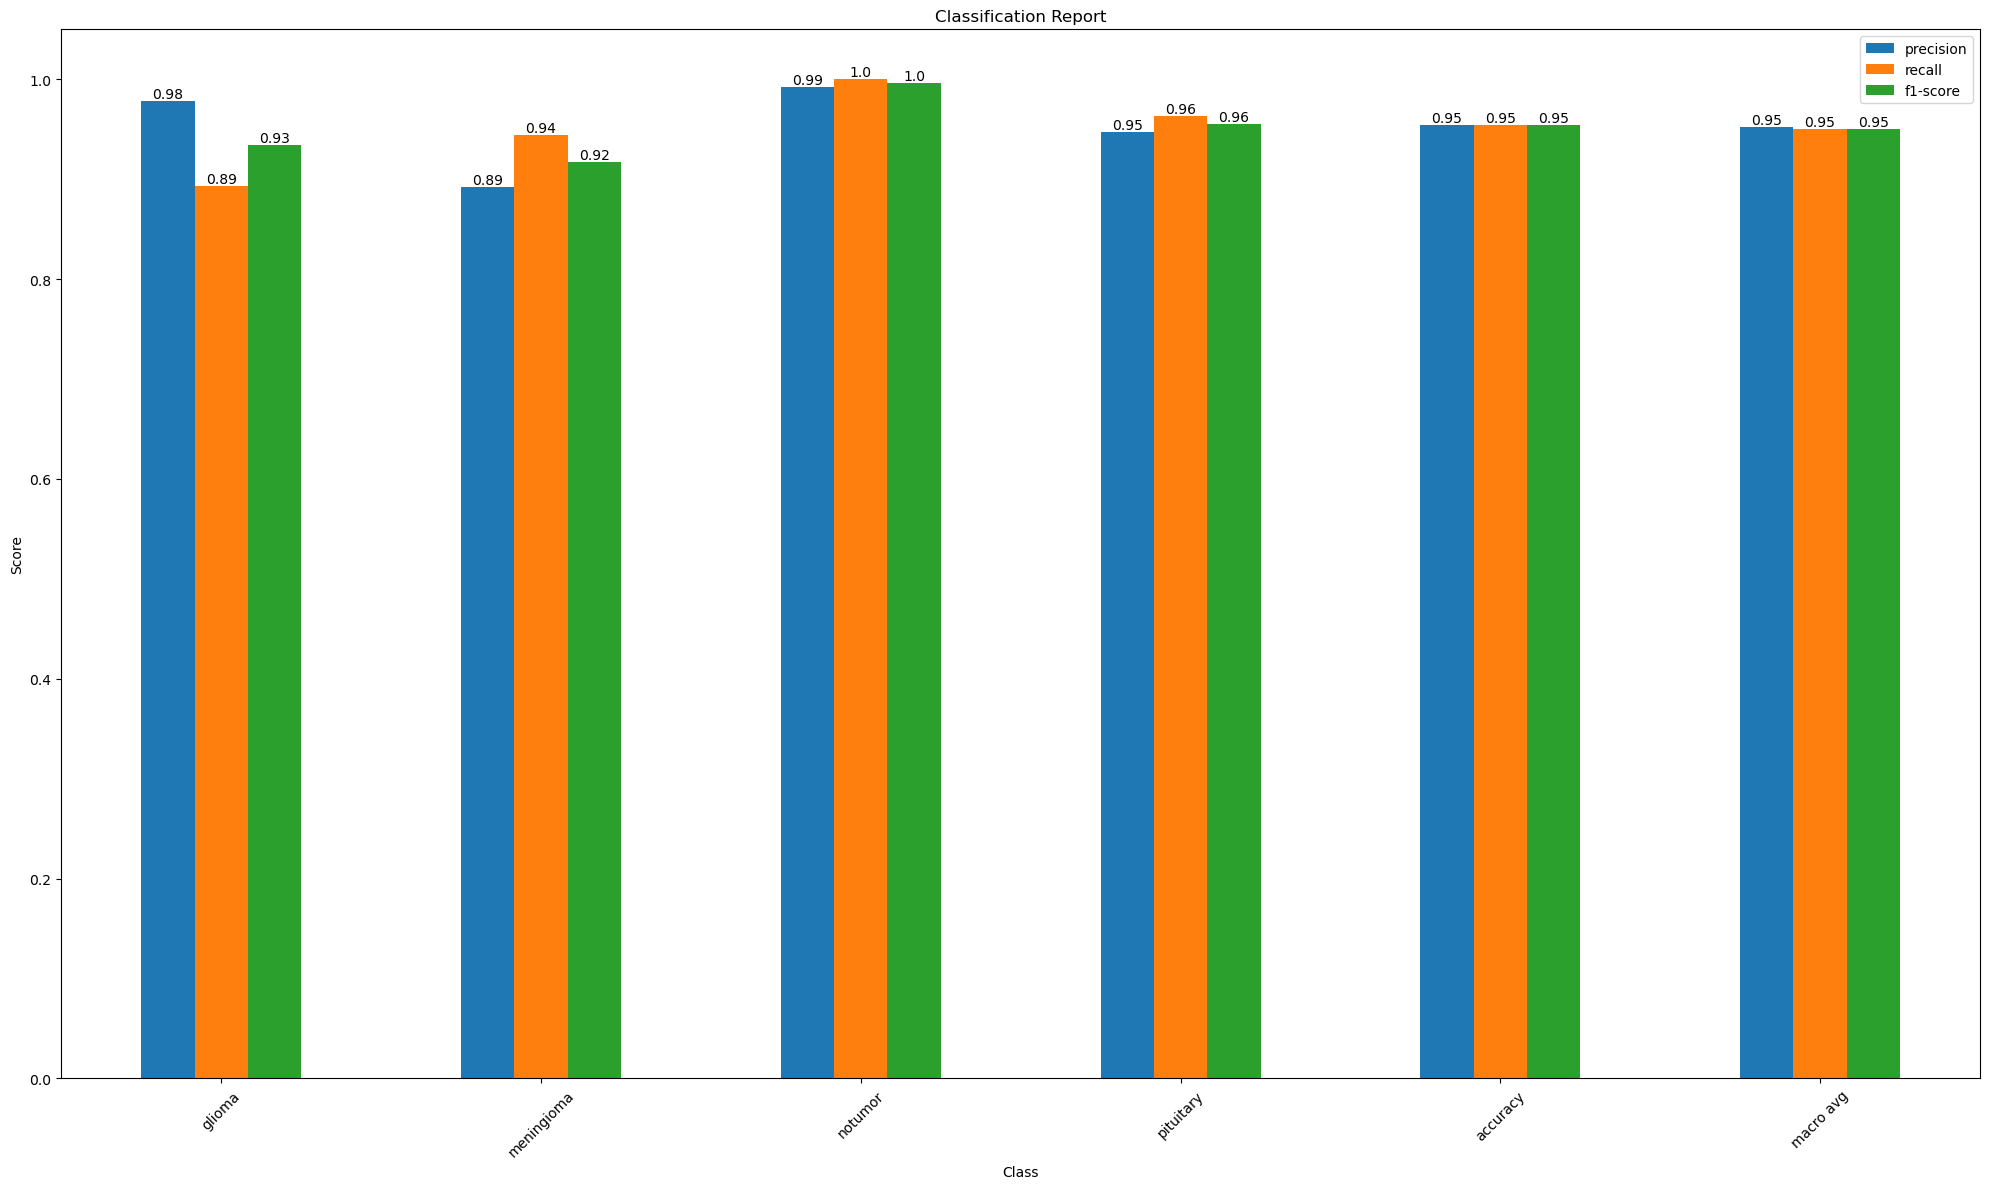

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming you have defined target_names as a list of class names
target_names = ['glioma', 'meningioma', 'notumor', 'pituitary']


# Convert report dictionary to DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot precision, recall, and F1-score for each class
df_plot = df_report[['precision', 'recall', 'f1-score']].iloc[:-1]
ax = df_plot.plot(kind='bar', figsize=(20, 12))
plt.title('Classification Report')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

# Annotate each bar with its respective score
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [21]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [22]:
def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    metrics = []

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = sum(confusion_matrix[j, i] for j in range(num_classes) if j != i)
        fn = sum(confusion_matrix[i, j] for j in range(num_classes) if j != i)
        tn = sum(confusion_matrix[j, j] for j in range(num_classes) if j != i) - fn
        
        metrics.append((tp, fp, fn, tn))

    return metrics

# Calculate metrics for each class
class_metrics = calculate_metrics(conf_matrix)

# Print results for each class
for i, (tp, fp, fn, tn) in enumerate(class_metrics):
    print(f"{classes[i]}:")
    print("True Positives (TP):", tp)
    print("False Positives (FP):", fp)
    print("False Negatives (FN):", fn)
    print("True Negatives (TN):", tn)
    print()


glioma:
True Positives (TP): 268
False Positives (FP): 6
False Negatives (FN): 32
True Negatives (TN): 951

meningioma:
True Positives (TP): 289
False Positives (FP): 35
False Negatives (FN): 17
True Negatives (TN): 945

notumor:
True Positives (TP): 405
False Positives (FP): 3
False Negatives (FN): 0
True Negatives (TN): 846

pituitary:
True Positives (TP): 289
False Positives (FP): 16
False Negatives (FN): 11
True Negatives (TN): 951



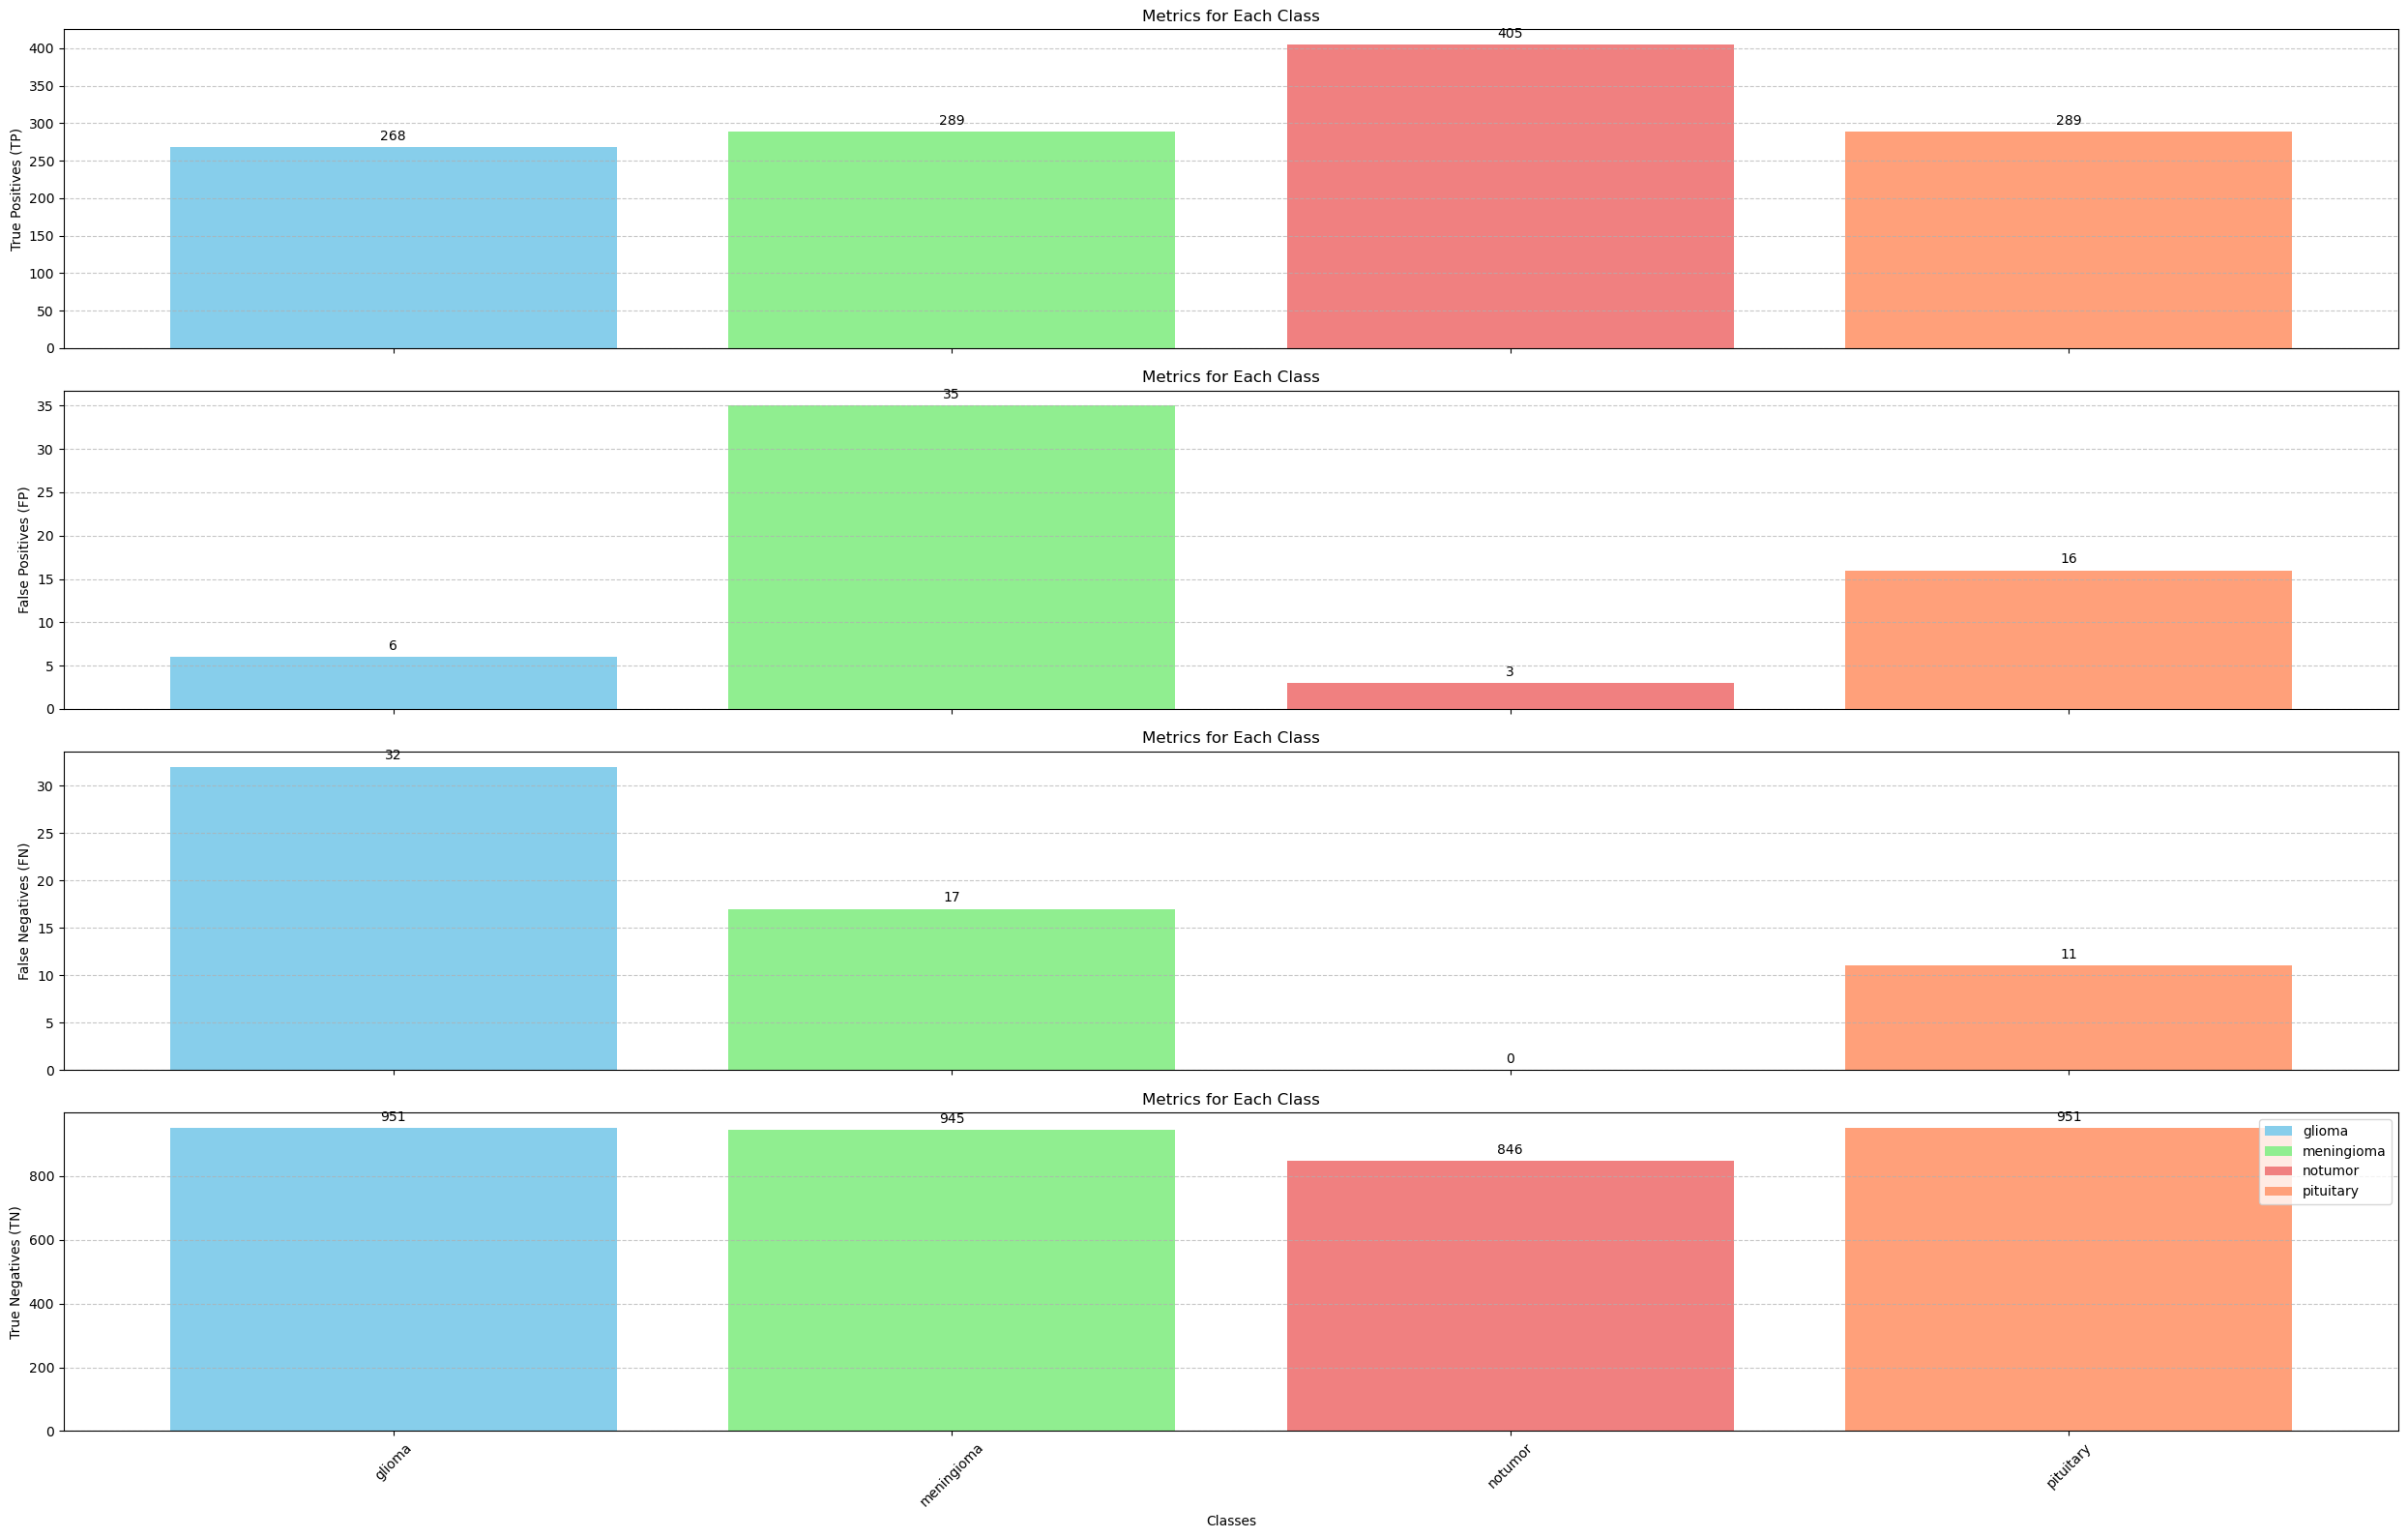

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define function to plot metrics
def plot_metrics(class_metrics, classes):
    # Convert metrics to numpy array for easier indexing
    metrics_array = np.array(class_metrics)
    num_metrics = metrics_array.shape[1]  # Number of metrics (TP, FP, FN, TN)

    # Define colors for each metric
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']
    metrics_labels = ['True Positives (TP)', 'False Positives (FP)', 'False Negatives (FN)', 'True Negatives (TN)']

    # Create subplots for each metric
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(25, 16), sharex=True)

    # Plot each metric with different color for each class
    for i in range(num_metrics):
        ax = axes[i]
        for j in range(len(classes)):
            bar = ax.bar(classes[j], metrics_array[j, i], color=colors[j], label=classes[j])
            # Annotate each bar with its respective score
            for rect in bar:
                height = rect.get_height()
                ax.annotate('{}'.format(round(height, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
        ax.set_ylabel(metrics_labels[i])
        ax.set_title(f'Metrics for Each Class')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Classes')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(loc='upper right')  # Show legend for class colors
    plt.tight_layout()
    plt.show()

# Plot metrics for each class
plot_metrics(class_metrics, classes)


In [24]:
def calculate_accuracy(tp, fp, fn, tn):
    if tp + fp + fn + tn == 0:
        return 0  # Handling division by zero
    return (tp + tn) / (tp + fp + fn + tn)

def calculate_acc_each_class(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    metrics = []

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = sum(confusion_matrix[j, i] for j in range(num_classes) if j != i)
        fn = sum(confusion_matrix[i, j] for j in range(num_classes) if j != i)
        tn = sum(confusion_matrix[j, j] for j in range(num_classes) if j != i) - fn

        accuracy = calculate_accuracy(tp, fp, fn, tn)
        metrics.append(accuracy)

    return metrics

# Calculate metrics for each class
class_metrics = calculate_acc_each_class(conf_matrix)

# Print results for each class
for i, accuracy in enumerate(class_metrics):
    print(f"{classes[i]}: Accuracy {accuracy:.2f}")



glioma: Accuracy 0.97
meningioma: Accuracy 0.96
notumor: Accuracy 1.00
pituitary: Accuracy 0.98


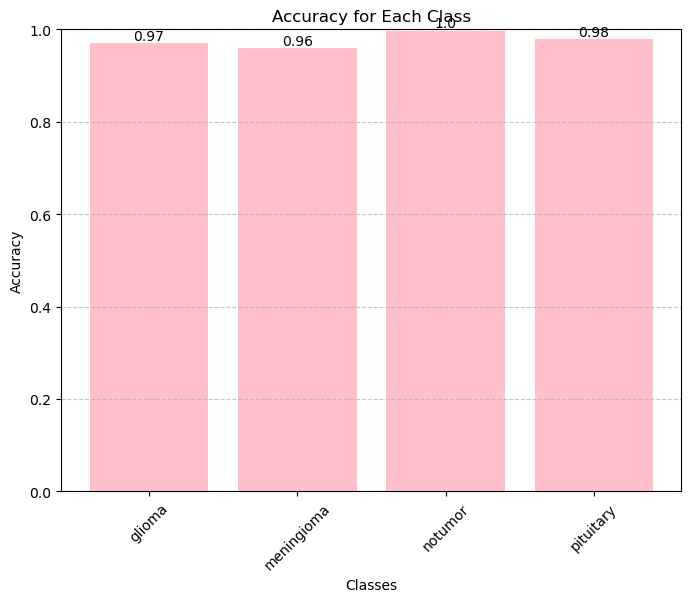

In [25]:
# Plot results for each class
plt.figure(figsize=(8, 6))
bars = plt.bar(classes, class_metrics, color='pink')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.ylim(0, 1)  # Set y-axis limits to ensure consistency
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its respective score
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)),
             ha='center', va='bottom')

plt.show()


In [26]:
def calculate_specificity(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    specificity = [0] * num_classes
    for i in range(num_classes):
        tn = sum(confusion_matrix[j, j] for j in range(num_classes) if j != i)
        fp = sum(confusion_matrix[j, i] for j in range(num_classes) if j != i)
        if tn + fp != 0:
            specificity[i] = tn / (tn + fp)
    return specificity


# Calculate specificity for each class
specificity = calculate_specificity(conf_matrix)

# Print the specificity for each class
for i, spec in enumerate(specificity):
    print(f"{classes[i]}: Specificity {spec:.2f}")


glioma: Specificity 0.99
meningioma: Specificity 0.96
notumor: Specificity 1.00
pituitary: Specificity 0.98


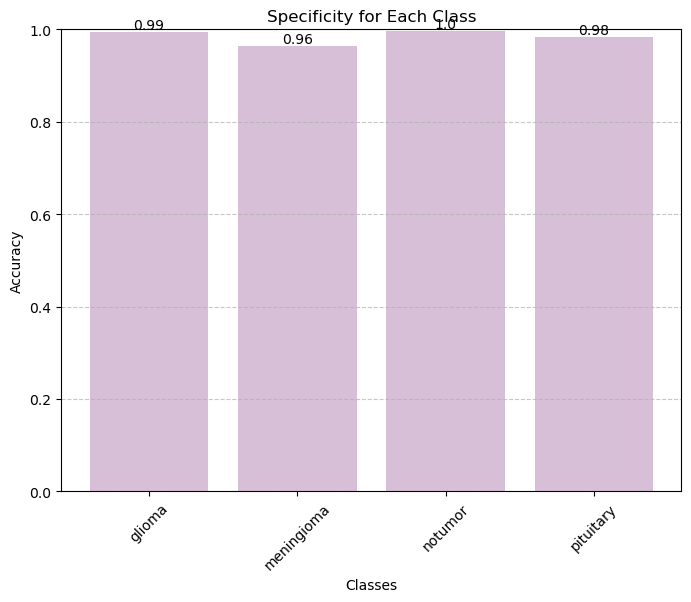

In [27]:
# Plot results for each class
plt.figure(figsize=(8, 6))
bars = plt.bar(classes, specificity, color='thistle')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Specificity for Each Class')
plt.ylim(0, 1)  # Set y-axis limits to ensure consistency
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its respective score
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)),
             ha='center', va='bottom')

plt.show()


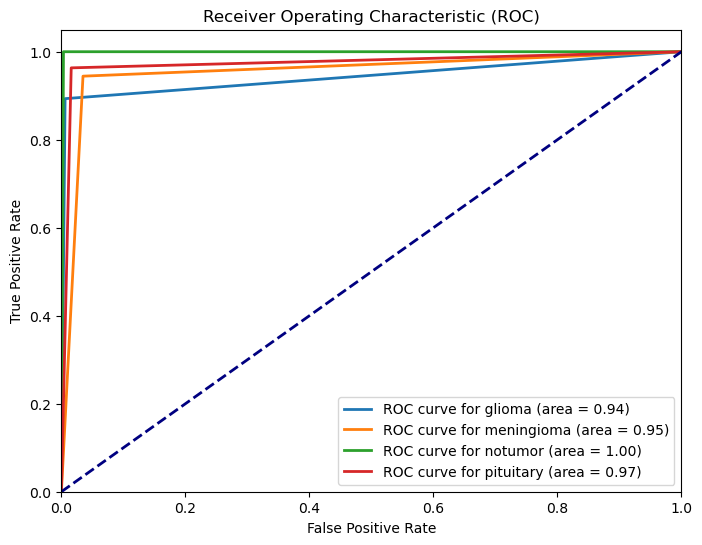

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, predicted_labels == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(target_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for {0} (area = {1:0.2f})'.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
